# Diabetes project

In [1403]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

## 1.1 Read SPSS databaseabs

In [1404]:
df_spss = pd.read_spss("DIALECT-1 + 2. definitief ruwe database (08-2019) met exclusie van dialect-1 patienten (n=671)_2.sav")


In [1405]:
df_spss

,Subjectnr,Geslacht,Leeftijd_poli1,Polidatum1,Polijaar_1,Polibezoek,Arts,Freq_arts,Freq_vp,Freq_tot,...,SumOfvite,SumOfrae,SumOffole,SumOfzink,SumOfdpa,SumOfarachidonz,SumOffolaat,SumOfnico,SumOfwater,SumOfnatrium
0,1.0,man,65.0,2009-08-31,2009.0,Eerste bezoek,Schot,4.0,0.0,4.0,...,13.267616,602.510257,173.289978,9.203426,0.000000,0.034463,173.289978,16.178387,1591.211480,2607.443336
1,2.0,man,61.0,2009-08-31,2009.0,Eerste bezoek,Oving,1.0,4.0,5.0,...,10.662237,645.575531,133.897548,7.454809,0.000010,0.047574,133.897548,16.796363,2216.603139,1891.477166
2,3.0,man,56.0,2009-08-31,2009.0,Eerste bezoek,Veneman,0.0,0.0,0.0,...,29.996976,1207.776682,209.312323,13.193616,0.000494,0.031634,205.339877,22.143815,2758.233627,3351.952037
3,4.0,vrouw,51.0,2009-08-31,2009.0,Eerste bezoek,Ouwehand,1.0,4.0,5.0,...,4.281328,218.128055,90.296190,5.820861,0.000057,0.039529,90.296190,5.644264,673.484131,1646.457431
4,5.0,vrouw,60.0,2009-08-31,2009.0,Eerste bezoek,van Zanten,1.0,4.0,5.0,...,16.653028,1482.346823,207.709797,10.275772,0.000243,0.079542,207.709797,18.294950,2028.428955,2972.889884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,732.0,vrouw,74.0,2019-05-22,2019.0,Eerste bezoek,van berkum,3.0,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,733.0,vrouw,28.0,2019-04-26,2019.0,Eerste bezoek,Visser,7.0,24.0,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,734.0,man,65.0,2019-05-08,2019.0,Eerste bezoek,de Vries,5.0,8.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
670,736.0,man,77.0,2019-05-22,2019.0,Eerste bezoek,Laverman,4.0,2.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1.2 Read Excel files

In [1406]:
def read_recursively(path: str) -> list:
    """Read the data for each one of the folder """
    paths = list(Path(path).iterdir())
    paths.sort()
    return {k: df for k, df in [process_folder(p) for p in paths]}


def process_folder(dir: Path) -> list:
    """Read the files from each folder"""
    path_name = dir / f"{dir.name}-steps.xlsx"
    if path_name.exists():
        df = pd.read_excel(path_name)
    else:
        df = None
    return dir.name, df

In [1407]:
time_series = read_recursively("Diabetes")
time_series.keys()

dict_keys(['353', '364', '369', '371', '380', '458', '466', '470', '471', '473', '476', '477', '479', '480', '482', '483', '485', '486', '487', '488', '489', '490'])

In [1408]:
df_353 = time_series['353']
df_353
df_353.columns

Index(['time', '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
       '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20'],
      dtype='object')

# 2 Features

* [x] Geslacht => new column called "Gender"
* [x] Leeftijd_poli1
* [x] Freq_tot
* [x] DMduur = polijaar_1 – Dmaanvang
* [x] Pack_years
* [x] Alcoholgebruik1EHpermaand
* [x] Lengte_poli1
* [x] Gewicht_poli1
* [x] Buikomvang_1
* [x] Heupomvang_1
* [x] SBP_poli1
* [x] DBP_poli1
* [x] Pols
* [x] Microvas_total (INPUT OR OUTPUT)
* [x] Macrovasculaire_ziekten (INPUT OR OUTPUT)
* [x] SerumHbA1c_1 (INPUT OR OUTPUT)
* [x] Serum_cholesterol_1
* [x] Total_number_drugs
* [x] Total_EH_Insulin = dosA10AB + dosA10AC + dosA10AD + dosA10AE. If there is no outcome (NaN), it should be filled in with 0.



## 3 Clean the dataframes

In [1409]:
def replace_with_mean_if_nan(df: pd.DataFrame, columns: list, max_nan: int = 50) -> pd:
    """Iterate over the columns of the dataframe and replace the nan values with the mean"""
    df_ml = pd.DataFrame()
    for c in columns:
        nas = df[c].isna().any().sum()
        if nas > max_nan:
            raise RuntimeError(f"Column {c} has more than {max_nan} NaN values!")
        elif df[c].isna().any():    
            df_ml[c] = df[c].fillna(df[c].mean())
        else:
            df_ml[c] = df[c]
    return df_ml

### 3.1 copy data to new DataFrame

In [1410]:
features = ["Leeftijd_poli1", "Freq_tot", "Pack_years", "Alcoholgebruik1EHpermaand", "Lengte_poli1","Gewicht_poli1", "Buikomvang_1", "Heupomvang_1", "Serum_cholesterol_1",
            "SerumHbA1c_1", "Total_number_drugs", "Microvas_total"]


In [1411]:

properties = df_spss[features]
properties[properties.isna().sum(axis=1) > 3].size

24

Copy features to an empty DataFrame

In [1412]:
df_ml = replace_with_mean_if_nan(df_spss, features)

Skip patients with More than 3 Nan in their features

In [1413]:
df_ml = df_ml[properties.isna().sum(axis=1) <= 3]

### 3.2 Clean  columns

In [1414]:
df_ml["Gender"] = df_spss["Geslacht"].apply(lambda x: 0.0 if x == "man" else 1.0)

In [1415]:
 df_ml["DMduur"] = df_spss["Polijaar_1"] - df_spss["DMaanvang"]

In [1416]:
df_ml["Total_EH_Insulin"] = df_spss["dosA10AB"].fillna(0) + df_spss["dosA10AC"].fillna(0) + df_spss["dosA10AD"].fillna(0) + df_spss["dosA10AE"].fillna(0)

In [1417]:
df_ml["Macrovasculaire_ziekten"] = df_spss["Macrovasculaire_ziekten"].apply(lambda x: 0.0 if x == "nee" else 1.0)

In [1418]:
df_ml["SBP"] = df_spss[['SBP1', 'SBP2', 'SBP3']].mean(axis=1)
df_ml["SBP"] = df_ml["SBP"].fillna(df_ml["SBP"].mean())

In [1419]:
df_ml["DBP"] = df_spss[['DBP1', 'DBP2', 'DBP3']].mean(axis=1)
df_ml["DBP"] = df_ml["DBP"].fillna(df_ml["DBP"].mean())

## 4 Visualize the Data

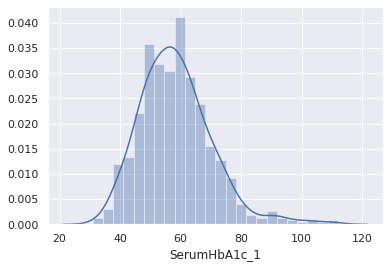

In [1420]:
sns.distplot(df_ml["SerumHbA1c_1"])

In [1421]:
df_ml["Microvas_total"][ df_ml["Microvas_total"] == 0.0].size

226

In [1422]:
df_ml["Macrovasculaire_ziekten"][df_ml["Macrovasculaire_ziekten"] == 0.0].size

429

## 5 Normalize Data

### 5.1 Select the features that  you want to train

In [1423]:
named_train_features = ["Leeftijd_poli1", "Freq_tot", "Pack_years", "Alcoholgebruik1EHpermaand", "Lengte_poli1","Gewicht_poli1", "Buikomvang_1", "Heupomvang_1", "Serum_cholesterol_1",
             "Total_number_drugs", "Gender","DMduur", "Total_EH_Insulin", "SBP", "DBP"]

In [1424]:
all_data = df_ml[named_train_features].to_numpy()
target = df_ml["SerumHbA1c_1"].to_numpy()

In [1425]:
target.shape

(670,)

In [1426]:
from sklearn.preprocessing import Normalizer
transformer_features = Normalizer()
normalized_features = transformer_features.transform(all_data)
normalized_target = target / np.sqrt(np.dot(target, target))


In [1427]:
all_data[0]

array([65.0, 4.0, 109.0, 29.0, 176.0, 117.0, 133.0, 116.0, 3.7, 8.0, 0.0,
       9.0, 96.0, 133.24865831842575, 73.90535714285714], dtype=object)

In [1428]:
normalized_features[0]

array([0.18358001, 0.01129723, 0.30784955, 0.08190493, 0.49707817,
       0.33044401, 0.37563294, 0.32761971, 0.01044994, 0.02259446,
       0.        , 0.02541877, 0.27113355, 0.37633523, 0.20873148])

### 5.2 Split the data into training and validation set

In [1429]:
number_of_patients = all_data.shape[0]
#indices = df_ml.index
indices = np.arange(number_of_patients)
frac_validation = 0.2
size_valid = int(len(indices) * frac_validation) 
index_valid = np.random.choice(indices, size=size_valid, replace=False)
index_train = np.setdiff1d(indices, index_valid, assume_unique=True)

In [1430]:
train_features = normalized_features[index_train]
valid_features = normalized_features[index_valid]
train_target =  normalized_target[index_train]
valid_target =  normalized_target[index_valid]
print(train_target.size)

536


## 6 Explore some Regression/Classification model

In [1431]:
def create_scatter_plot(predicted: np.ndarray, expected: np.ndarray, workdir: str = ".") -> None:
    """Plot the predicted vs the expected values."""
    predicted = predicted.flatten()
    expected = expected.flatten()
    sns.set()

    df = pd.DataFrame({'expected': expected, 'predicted': predicted})

    sns.regplot(x='expected', y='predicted', data=df)

### 6.1 Random Forest Regressor

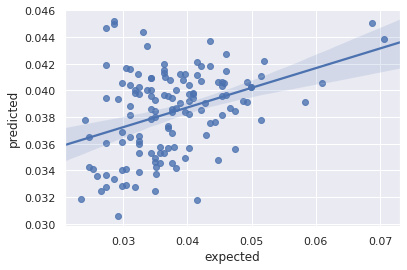

In [1432]:
from sklearn.ensemble import RandomForestRegressor
sklearn_model = RandomForestRegressor(n_estimators=100)
# Train data
sklearn_model.fit(train_features, train_target)
predicted = sklearn_model.predict(valid_features)
# Plot the expected and predicted value
create_scatter_plot(predicted, valid_target)

In [1433]:
importances = sklearn_model.feature_importances_
importances[0]
{key: importances[i]  for i, key in enumerate(named_train_features)}

{'Leeftijd_poli1': 0.06904310044080543,
 'Freq_tot': 0.05873884657215488,
 'Pack_years': 0.047450726918678646,
 'Alcoholgebruik1EHpermaand': 0.04665231616910463,
 'Lengte_poli1': 0.058655355611466085,
 'Gewicht_poli1': 0.048210100373900104,
 'Buikomvang_1': 0.05637348684283566,
 'Heupomvang_1': 0.0657356486335821,
 'Serum_cholesterol_1': 0.10107003091742042,
 'Total_number_drugs': 0.06332003993558157,
 'Gender': 0.03454337626406379,
 'DMduur': 0.10180073706994108,
 'Total_EH_Insulin': 0.141748843421819,
 'SBP': 0.055515037209552406,
 'DBP': 0.051142353619094146}

### Random Forest Classifier

In [1434]:
from sklearn.ensemble import RandomForestClassifier
sklearn_model = RandomForestClassifier(n_estimators=100)
# Train data
labels = df_ml["Microvas_total"].apply(lambda x: 1 if x >  0.0 else 0).to_numpy().astype(np.int)
sklearn_model.fit(train_features, labels[index_train])
predicted = sklearn_model.predict(valid_features)


In [1435]:
sklearn_model.score(valid_features, labels[index_valid])

0.6343283582089553

### 6.2 BaggingRegressor

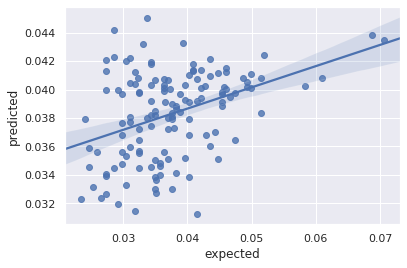

In [1436]:
from sklearn.ensemble import BaggingRegressor
sklearn_model = BaggingRegressor(n_estimators=100)
# Train data
sklearn_model.fit(train_features, train_target)
predicted = sklearn_model.predict(valid_features)
# Plot the expected and predicted value
create_scatter_plot(predicted, valid_target)

### 6.3 Logistic Regression

In [1437]:
from sklearn.linear_model import LogisticRegression
sklearn_model = LogisticRegression()
sklearn_model.fit(train_features, labels[index_train])
predicted = sklearn_model.predict(valid_features)

In [1438]:
sklearn_model.score(valid_features, labels[index_valid])

0.6716417910447762

### 6.4 A simple Deep Feedforward Network using Pytorch
pytorch installation: ```conda install pytorch torchvision cpuonly -c pytorch```

In [1439]:
import torch
from torch import Tensor, nn

# Definition of the neural network
class FullyConnected(nn.Module):
    """Fully connected network for non-linear regression."""

    def __init__(self, n_feature: int, n_hidden: int):
        """Create a deep feed foward network."""
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(n_feature, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            # nn.Softmax(),
            # nn.Linear(n_hidden, 2)
            nn.ReLU(),
            nn.Linear(n_hidden, 1),
        )

    def forward(self, tensor: Tensor) -> Tensor:
        """Run the model."""
        return self.seq(tensor)

In [1440]:

def train_batch(tensor: Tensor, y_batch) -> float:
    """Train a single batch."""
    prediction = network(tensor)
    loss = loss_func(prediction.view(-1), y_batch.view(-1))
    loss.backward()              # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    optimizer.zero_grad()   # clear gradients for next train

    return loss.item()

In [1441]:
# Select the device to run the training
device = torch.device("cpu")

# Create neural network
network = FullyConnected(15, 10)
network = network.to(device)

# Create optimizer
optimizer = torch.optim.SGD(network.parameters(), lr=0.2)

# Losss function
loss_func = nn.MSELoss()

### Training

In [1442]:
# Make the data torch Tensor
train_tensor = torch.from_numpy(train_features.astype(np.float32))
train_target = torch.from_numpy(train_target.astype(np.float32))
print(train_tensor.shape)

# Train the model
network.train()
loss_all = np.empty(100)
for k, epoch in enumerate(range(100)):
    loss = train_batch(train_tensor, train_target) * len(train_tensor)
    loss_all[k] = loss / len(train_tensor)
print(loss_all)

torch.Size([536, 15])
[1.20589565e-02 3.54497833e-03 1.06456538e-03 3.53089912e-04
 1.51003347e-04 9.39244856e-05 7.78490066e-05 7.33248671e-05
 7.20483949e-05 7.16839932e-05 7.15756396e-05 7.15391288e-05
 7.15227798e-05 7.15120914e-05 7.15029964e-05 7.14943599e-05
 7.14858543e-05 7.14773996e-05 7.14689959e-05 7.14605703e-05
 7.14521884e-05 7.14438211e-05 7.14354974e-05 7.14271300e-05
 7.14188209e-05 7.14104899e-05 7.14021589e-05 7.13938716e-05
 7.13855479e-05 7.13772679e-05 7.13689733e-05 7.13607005e-05
 7.13524278e-05 7.13441768e-05 7.13359404e-05 7.13276531e-05
 7.13194240e-05 7.13112095e-05 7.13029731e-05 7.12947804e-05
 7.12865440e-05 7.12783585e-05 7.12701585e-05 7.12619731e-05
 7.12537876e-05 7.12455876e-05 7.12373803e-05 7.12292021e-05
 7.12210458e-05 7.12128749e-05 7.12047040e-05 7.11965549e-05
 7.11884131e-05 7.11802713e-05 7.11721223e-05 7.11640241e-05
 7.11559260e-05 7.11478351e-05 7.11397443e-05 7.11316679e-05
 7.11235771e-05 7.11155153e-05 7.11074536e-05 7.10993772e-05
 7

### Validation

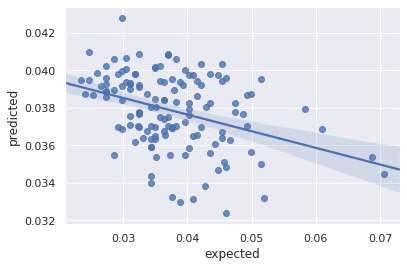

In [1443]:
valid_tensor = torch.from_numpy(valid_features.astype(np.float32))
valid_target = torch.from_numpy(valid_target.astype(np.float32))
with torch.no_grad():
    network.eval()
    loss_all = 0
    predicted = network(valid_tensor)
    loss = loss_func(predicted.view(-1), valid_target)
    loss_all = loss / len(valid_tensor)

create_scatter_plot(predicted.detach().numpy(), valid_target)